In [43]:
import numpy as np
from scipy import linalg
from scipy.special import binom
import matplotlib.pyplot as plt
import itertools as it
import copy
import stomp_functions as stf
from qiskit.quantum_info import Operator, Pauli, SparsePauliOp, random_clifford
import time
import os
import re
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from qiskit.quantum_info import random_clifford
import statsmodels.stats.api as sms

In [44]:
def create_H(N, g, j):
    """
    function for creating the ising model Hamiltonian used in the sampler calculations
    :param N:  number of sites
    :param g:  transverse field strength
    :param j:  nearest neighbor interaction
    :return:   the system hamiltonian
    """
    z_ops, x_ops = stf.construct_op_lists(N)
    H_qis = SparsePauliOp("I" * N, coeffs=[0.0])  # start with zero operator
    for n in range(N - 1):
        H_qis += float(-j) * (z_ops[n] @ z_ops[n+1])
    for m in range(N):
        H_qis += float(-j * g) * x_ops[m]
    return H_qis
 


In [45]:
class TOLcmaps(object):
    """
    Class TOLcmaps definition.  Used for generating color map for plots
    """
    def __init__(self):
        """
        """
        self.cmap = None
        self.cname = None
        self.namelist = (
            'rainbow_PuRd',)

        self.funcdict = dict(
            zip(self.namelist,
                (self.__rainbow_PuRd,
                )
               )
        )
        
    def __rainbow_PuRd(self):
        """
        Define colormap 'rainbow_PuRd'.
        """
        clrs = ['#6F4C9B', '#6059A9', '#5568B8', '#4E79C5', '#4D8AC6',
                '#4E96BC', '#549EB3', '#59A5A9', '#60AB9E', '#69B190',
                '#77B77D', '#8CBC68', '#A6BE54', '#BEBC48', '#D1B541',
                '#DDAA3C', '#E49C39', '#E78C35', '#E67932', '#E4632D',
                '#DF4828', '#DA2222']
        self.cmap = LinearSegmentedColormap.from_list(self.cname, clrs)
        self.cmap.set_bad('#FFFFFF')
        
    def get(self, cname='rainbow_PuRd', lut=None):
        """
        Return requested colormap, default is 'rainbow_PuRd'.
        """
        self.cname = cname
        if cname == 'rainbow_discrete':
            self.__rainbow_discrete(lut)
        else:
            self.funcdict[cname]()
        return self.cmap

In [46]:
def tol_cmap(colormap=None, lut=None):
    """
    Continuous and discrete color sets for ordered data.
    
    Return a matplotlib colormap.
    Parameter lut is ignored for all colormaps except 'rainbow_discrete'.
    """
    obj = TOLcmaps()
    if colormap is None:
        return obj.namelist
    if colormap not in obj.namelist:
        colormap = 'rainbow_PuRd'
        print('*** Warning: requested colormap not defined,',
              'known colormaps are {}.'.format(obj.namelist),
              'Using {}.'.format(colormap))
    return obj.get(colormap, lut)

In [47]:
# Set font size of plot elements
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [48]:
# Define Hamiltonian parameters
N = 2
g = 2
j = 1

In [49]:
# Create the Hamiltonian
H = create_H(N, g, j)

# Get energy eigenvalues
E = linalg.eigvalsh(H.to_matrix())

In [50]:
# Define filenames for reading data
ovlp_file = "corr_sampler_ovlp_N=2_ibm_brisbane_b=1_numsteps=100_g=2.npz"
H_ovlp_file = "corr_sampler_H_ovlp_N=2_ibm_brisbane_b=1_numsteps=100_g=2.npz"

In [51]:
# Load in data
ovlp_data = np.load(ovlp_file, allow_pickle=True)
H_ovlp_data = np.load(H_ovlp_file, allow_pickle=True)

In [52]:
# Get beta value and numsteps from filename
τ = float(re.search(r'b=\d', ovlp_file).group(0)[2:])
num_steps = int(re.search(r'numsteps=\d+', ovlp_file).group(0)[9:])
τs, dτ = np.linspace(0, τ, num_steps, retstep=True)

In [53]:
# Average over the input states used in the simulation
avg_ovlp = np.mean(list(ovlp_data.values()), axis=0)
avg_H_ovlp = np.mean(list(H_ovlp_data.values()), axis=0)

Text(0, 0.5, 'Im($\\langle \\psi_{2j} | \\psi_{-2j} \\rangle$)')

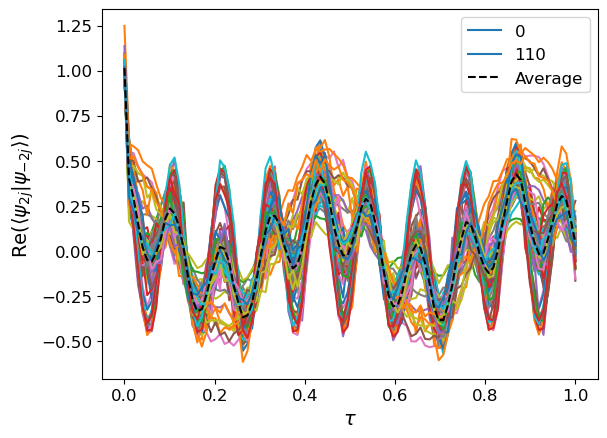

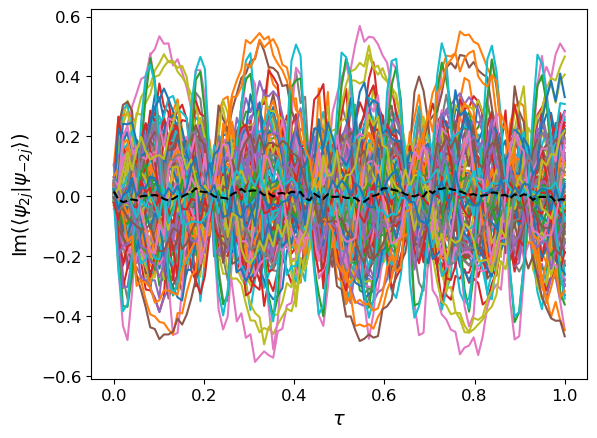

In [54]:
# Just plot all the overlap data
fig = plt.figure(1)
ax = fig.add_subplot(111)
fig2 = plt.figure(2)
ax2 = fig2.add_subplot(111)
for key in ovlp_data:
    if key == list(ovlp_data.keys())[0] or key == list(ovlp_data.keys())[-1]:
        ax.plot(τs, ovlp_data[key].real, label=key)
        ax2.plot(τs, ovlp_data[key].imag, label=key)
    else:
        ax.plot(τs, ovlp_data[key].real)
        ax2.plot(τs, ovlp_data[key].imag)

ax.plot(τs, avg_ovlp.real, 'k--', label='Average')
ax2.plot(τs, avg_ovlp.imag, 'k--')
ax.set_xlabel("$\\tau$")
ax.set_ylabel("Re($\\langle \\psi_{2j} | \\psi_{-2j} \\rangle$)")
ax.legend()

ax2.set_xlabel("$\\tau$")
ax2.set_ylabel("Im($\\langle \\psi_{2j} | \\psi_{-2j} \\rangle$)")

Text(0, 0.5, 'Im($\\langle \\psi_{2j} |O| \\psi_{-2j} \\rangle$)')

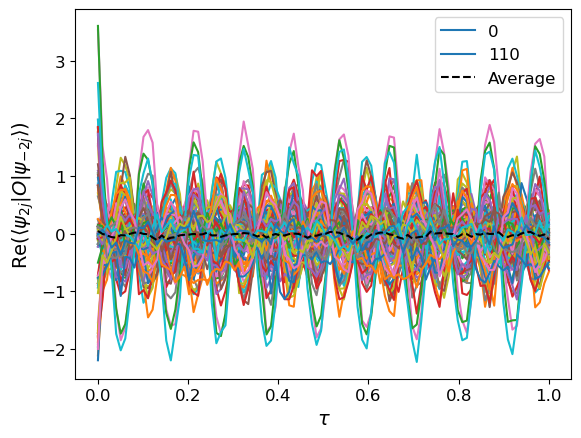

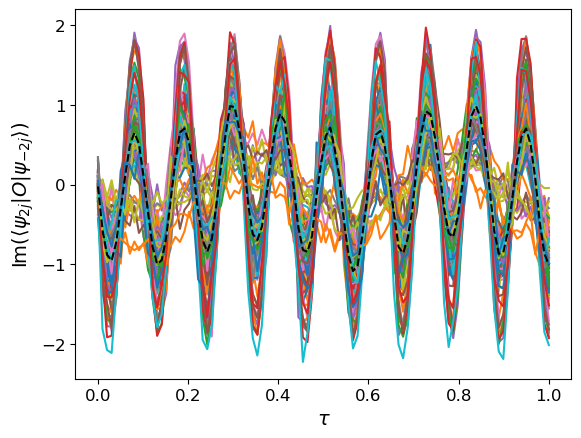

In [55]:
# Just plot all the overlap data
fig = plt.figure(1)
ax = fig.add_subplot(111)
fig2 = plt.figure(2)
ax2 = fig2.add_subplot(111)
for key in ovlp_data:
    if key == list(ovlp_data.keys())[0] or key == list(ovlp_data.keys())[-1]:
        ax.plot(τs, H_ovlp_data[key].real, label=key)
        ax2.plot(τs, H_ovlp_data[key].imag, label=key)
    else:
        ax.plot(τs, H_ovlp_data[key].real)
        ax2.plot(τs, H_ovlp_data[key].imag)

ax.plot(τs, avg_H_ovlp.real, 'k--', label='Average')
ax2.plot(τs, avg_H_ovlp.imag, 'k--')
ax.set_xlabel("$\\tau$")
ax.set_ylabel("Re($\\langle \\psi_{2j} |O| \\psi_{-2j} \\rangle$)")
ax.legend()

ax2.set_xlabel("$\\tau$")
ax2.set_ylabel("Im($\\langle \\psi_{2j} |O| \\psi_{-2j} \\rangle$)")

In [56]:
# Compare average of our samplers to classical calculation
class_ovlp, class_H_ovlp = {},  {}
for key in ovlp_data:
    temp = np.zeros(2 ** N, dtype=complex)
    temp[1] = 1
    init_state = random_clifford(N, seed=int(key)).to_matrix() @ temp
    class_ovlp[key], class_H_ovlp[key] = stf.classical_calc(init_state, H.to_matrix(),
                                                            H.to_matrix(), num_steps, dτ)

In [57]:
# Average the classical results as well
avg_class_ovlp = np.mean(list(class_ovlp.values()), axis=0)
avg_class_H_ovlp = np.mean(list(class_H_ovlp.values()), axis=0)

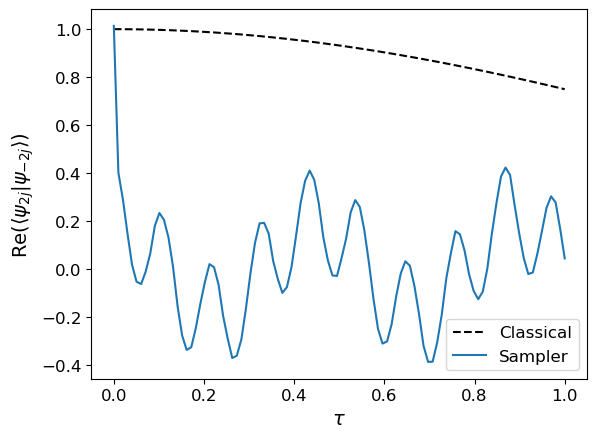

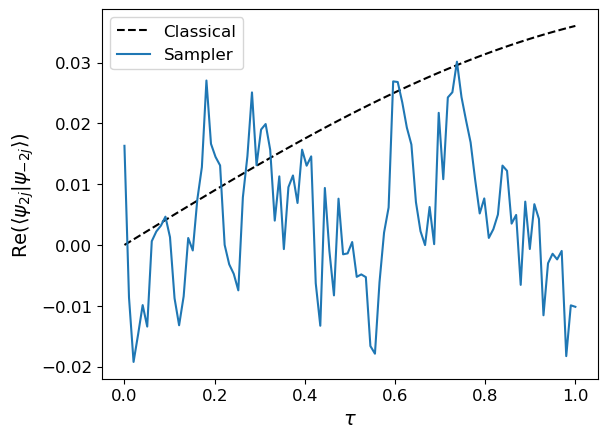

In [58]:
# Compare the classical and sampler overlap lists
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.plot(τs, avg_class_ovlp.real, 'k--', label='Classical')
ax.plot(τs, avg_ovlp.real, label='Sampler')
ax.set_xlabel("$\\tau$")
ax.set_ylabel("Re($\\langle \\psi_{2j} | \\psi_{-2j} \\rangle$)")
ax.legend()

fig2 = plt.figure(2)
ax2 = fig2.add_subplot(111)
ax2.plot(τs, avg_class_ovlp.imag, 'k--', label='Classical')
ax2.plot(τs, avg_ovlp.imag, label='Sampler')
ax2.set_xlabel("$\\tau$")
ax2.set_ylabel("Re($\\langle \\psi_{2j} | \\psi_{-2j} \\rangle$)")
ax2.legend()

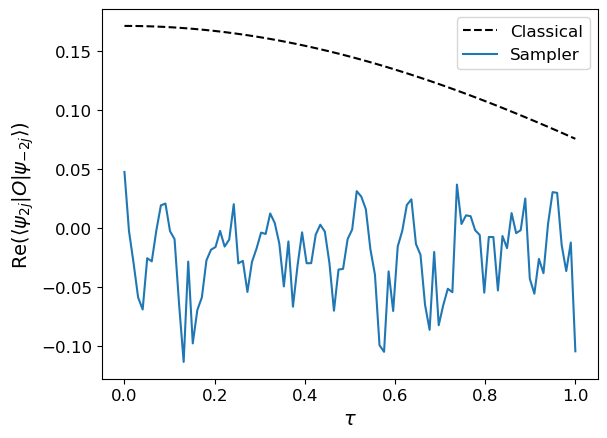

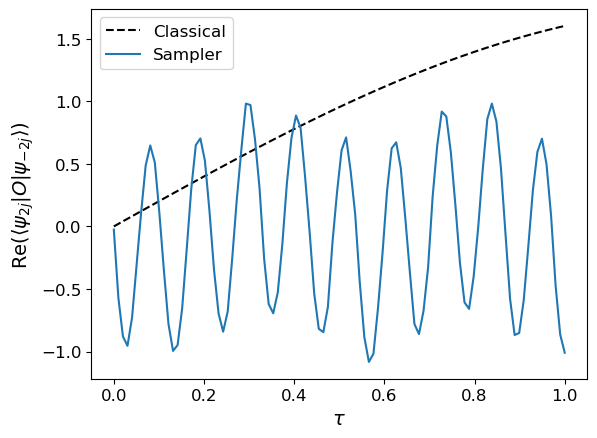

In [59]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.plot(τs, avg_class_H_ovlp.real, 'k--', label='Classical')
ax.plot(τs, avg_H_ovlp.real, label='Sampler')
ax.set_xlabel("$\\tau$")
ax.set_ylabel("Re($\\langle \\psi_{2j} |O| \\psi_{-2j} \\rangle$)")
ax.legend()

fig2 = plt.figure(2)
ax2 = fig2.add_subplot(111)
ax2.plot(τs, avg_class_H_ovlp.imag, 'k--', label='Classical')
ax2.plot(τs, avg_H_ovlp.imag, label='Sampler')
ax2.set_xlabel("$\\tau$")
ax2.set_ylabel("Re($\\langle \\psi_{2j} |O| \\psi_{-2j} \\rangle$)")
ax2.legend()

In [60]:
# Calculate energies for different λ as the system evolves in imaginary time
mean_E = {}
for λ in E:
    mean_E[λ] = stf.alt_partition_calc(avg_ovlp, avg_H_ovlp, num_steps, λ, dτ)[1][1:] - λ

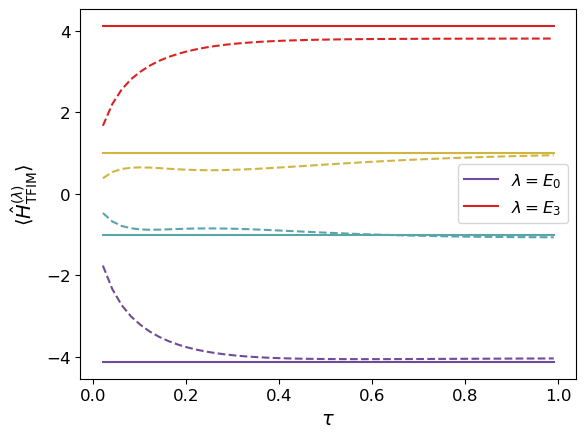

In [61]:
# Plot the energy values
colors = tol_cmap('rainbow_PuRd').resampled(len(list(mean_E.values())))
for i, λ in enumerate(E):
    plt.plot(τs[2::2], mean_E[λ], '--', color=colors(i))
    if i == 0 or i == E.size-1:
        plt.plot(τs[2::2], λ * np.ones(τs[2::2].size), color=colors(i), label='$\\lambda=E_'+str(i)+'$')
    else:
        plt.plot(τs[2::2], λ * np.ones(τs[2::2].size), color=colors(i))
plt.legend()
plt.xlabel("$\\tau$")
plt.ylabel("$\\langle\\hat{H}^{(\\lambda)}_{\\mathrm{TFIM}}\\rangle$")
plt.savefig("sampler_result.png", format='png', dpi=300)

In [62]:
# Sweep over λ
λs = np.linspace(-1.1 * abs(E[0]), 1.1 * abs(E[0]), 100)
calculated_energies = [stf.alt_partition_calc(avg_ovlp, avg_H_ovlp,
                                                  num_steps, _, dτ)[1][-1]
                      for _ in λs]

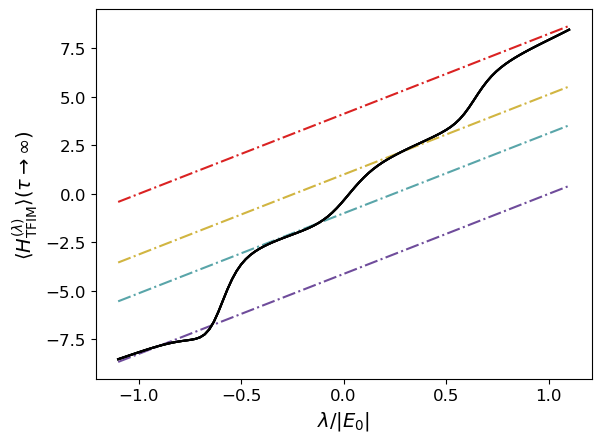

In [63]:
# Plot the final calculated energy value as λ varies
for i, e in enumerate(E):
    plt.plot(λs / abs(E[0]), e * np.ones(λs.shape[0]) + λs,
            '-.', color=colors(i))
    plt.plot(λs / abs(E[0]), calculated_energies, 'k')
    
plt.ylabel("$\\langle H^{(\\lambda)}_{\\mathrm{TFIM}} \\rangle(\\tau \\rightarrow \\infty)$")
plt.xlabel("$\\lambda/|E_0|$")
plt.savefig("sampler_sweep_results.png", format='png', dpi=300)

In [64]:
# Calculate error compared to exact eigenvalues obtained via diagonalization
err = {}
for λ in E:
    err[λ] = np.abs(λ - mean_E[λ][-1]) / np.abs(λ)

Text(0, 0.5, 'Rel. Err (%)')

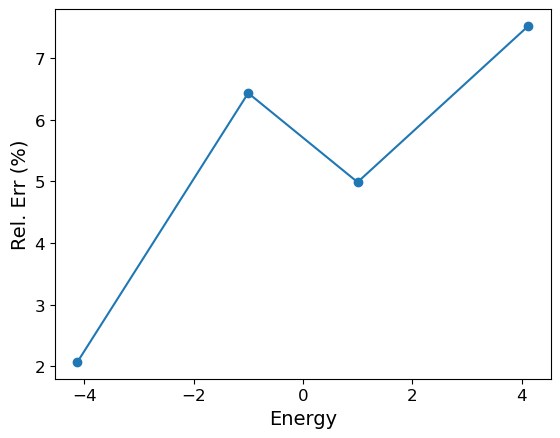

In [65]:
# Plot the relative error in each eigenvalue
plt.plot(E, np.array(list(err.values())) * 100, 'o-')
plt.xlabel("Energy")
plt.ylabel("Rel. Err (%)")

## Plot with Errorbars

In [66]:
# Stack each list of overlaps
temp_z = np.vstack(list(ovlp_data.values()))
temp_z = temp_z.T

# For each step, calculate the mean and the confidence intervals
mean_z = np.zeros(temp_z.shape[0], dtype=complex)
z_conf_int = np.zeros(temp_z.shape[0], dtype=complex)
for i, step in enumerate(temp_z):
    mean_z[i] = np.mean(temp_z[i])
    lo, up = sms.DescrStatsW(temp_z[i].real).tconfint_mean()
    z_conf_int[i] = ((up - lo) / 2)
    lo, up = sms.DescrStatsW(temp_z[i].imag).tconfint_mean()
    z_conf_int[i] += 1j*((up - lo) / 2)
z_conf_int = np.array(z_conf_int)

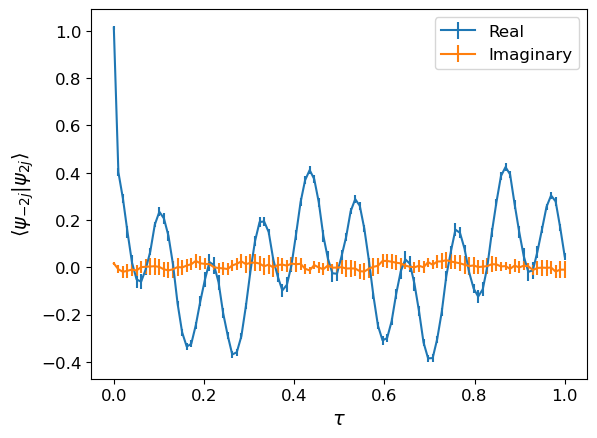

In [67]:
# Plot average overlap values with errorbars
plt.errorbar(τs, mean_z.real, yerr=z_conf_int.real, label='Real')
plt.errorbar(τs, mean_z.imag, yerr=z_conf_int.imag, label='Imaginary')
plt.xlabel("$\\tau$")
plt.ylabel("$\\langle \\psi_{-2j} | \\psi_{2j} \\rangle$")
plt.legend()

True


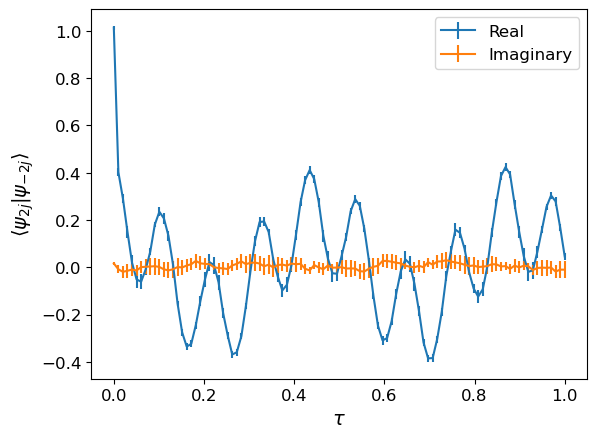

In [68]:
# Just do comparison to the student t distribution
import scipy.stats as stats
temp_z = np.vstack(list(ovlp_data.values()))
temp_z = temp_z.T

# For each step, calculate the mean and the confidence intervals
st_mean_z = np.zeros(temp_z.shape[0], dtype=complex)
st_z_conf_int = np.zeros(temp_z.shape[0], dtype=complex)
for i, step in enumerate(temp_z):
    st_mean_z[i] = np.mean(temp_z[i])
    rlo, rup = stats.t.interval(0.95, len(temp_z[i])-1, loc=st_mean_z[i].real,
                                     scale=stats.sem(temp_z[i].real))
    ilo, iup = stats.t.interval(0.95, len(temp_z[i])-1, loc=st_mean_z[i].imag,
                                     scale=stats.sem(temp_z[i].imag))
    st_z_conf_int[i] = (rup - rlo) / 2 + 1j * (iup - ilo) / 2

plt.errorbar(τs, st_mean_z.real, yerr=st_z_conf_int.real, label='Real')
plt.errorbar(τs, st_mean_z.imag, yerr=st_z_conf_int.imag, label='Imaginary')
plt.xlabel("$\\tau$")
plt.ylabel("$\\langle \\psi_{2j} | \\psi_{-2j} \\rangle$")
plt.legend()
print(np.allclose(z_conf_int, st_z_conf_int))

In [69]:
# Now do same for observable data
temp_O = np.vstack(list(H_ovlp_data.values()))
temp_O = temp_O.T

# For each step, calculate the mean and the confidence intervals
mean_O = np.zeros(temp_O.shape[0], dtype=complex)
O_conf_int = np.zeros(temp_O.shape[0], dtype=complex)
for i, step in enumerate(temp_O):
    mean_O[i] = np.mean(temp_O[i])
    lo, up = sms.DescrStatsW(temp_O[i].real).tconfint_mean()
    O_conf_int[i] = ((up - lo) / 2)
    lo, up = sms.DescrStatsW(temp_O[i].imag).tconfint_mean()
    O_conf_int[i] += 1j*((up - lo) / 2)
O_conf_int = np.array(O_conf_int)

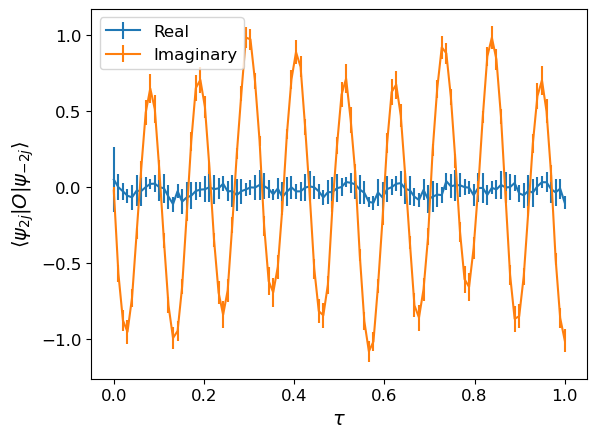

In [70]:
# Plot average overlap values with errorbars
plt.errorbar(τs, mean_O.real, yerr=O_conf_int.real, label='Real')
plt.errorbar(τs, mean_O.imag, yerr=O_conf_int.imag, label='Imaginary')
plt.xlabel("$\\tau$")
plt.ylabel("$\\langle \\psi_{2j} | O | \\psi_{-2j} \\rangle$")
plt.legend()

In [71]:
# Now propagate error through to the energy results
prop_err = np.zeros((E.size, τs[2::2].size), dtype=complex)
prop_err.shape
for i, λ in enumerate(E):
    for j, m in enumerate(range(3, num_steps, 2)):
        Z = 0
        O = 0
        unc_sum_z_r = 0
        unc_sum_z_i = 0
        unc_sum_O_r = 0
        unc_sum_O_i = 0
        for k in range(0, m, 2):
            ck = np.exp(-2*(int(k/2) - m /2) ** 2 / m + 2j * λ * np.sqrt(0.5 * dτ) * (m - k))
            Z += 2 * (ck * mean_z[m-k]).real
            O += 2 * (ck * mean_O[m-k]).real
            unc_sum_z_r += np.abs(ck.real) ** 2 * np.abs(z_conf_int[m-k].real) ** 2
            unc_sum_z_i += np.abs(ck.imag) ** 2 * np.abs(z_conf_int[m-k].imag) ** 2
            unc_sum_O_r += np.abs(ck.real) ** 2 * np.abs(O_conf_int[m-k].real) ** 2
            unc_sum_O_i += np.abs(ck.imag) ** 2 * np.abs(O_conf_int[m-k].imag) ** 2
            
        prop_err[i][j] = np.sqrt(1 / np.abs(Z) ** 2 * unc_sum_O_r +
                                 1 / np.abs(Z) ** 2 * unc_sum_O_i +
                                 np.abs(O) ** 2 / np.abs(Z) ** 4 * unc_sum_z_r +
                                np.abs(O) ** 2 / np.abs(Z) ** 4 * unc_sum_z_i)

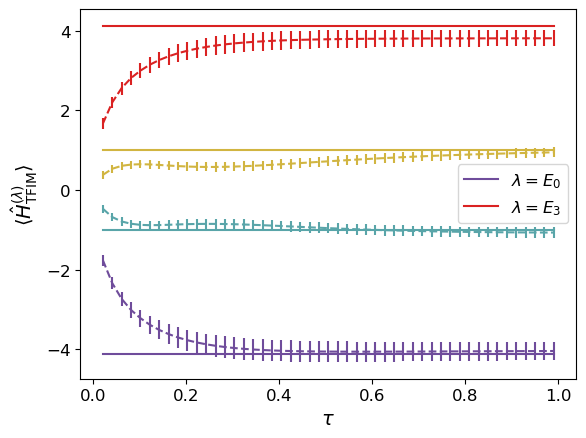

In [72]:
# Plot energy results with errobars
colors = tol_cmap('rainbow_PuRd').resampled(len(list(mean_E.values())))
for i, λ in enumerate(E):
    plt.errorbar(τs[2::2], mean_E[λ], yerr=prop_err[i], color=colors(i), linestyle='--')
    if i == 0 or i == E.size-1:
        plt.plot(τs[2::2], λ * np.ones(τs[2::2].size), color=colors(i), label='$\\lambda=E_'+str(i)+'$')
    else:
        plt.plot(τs[2::2], λ * np.ones(τs[2::2].size), color=colors(i))
plt.legend()
plt.xlabel("$\\tau$")
plt.ylabel("$\\langle\\hat{H}^{(\\lambda)}_{\\mathrm{TFIM}}\\rangle$")
plt.savefig("sampler_result.png", format='png', dpi=300)

In [73]:
λs = np.linspace(-1.1 * abs(E[0]), 1.1 * abs(E[0]), 100)
sweep_prop_err = np.zeros(λs.size, dtype=complex)
for i, λ in enumerate(λs):
    Z = 0
    O = 0
    unc_sum_z_r = 0
    unc_sum_z_i = 0
    unc_sum_O_r = 0
    unc_sum_O_i = 0
    for k in range(0, num_steps, 2):
        ck = np.exp(-2*(int(k/2) - m /2) ** 2 / m + 2j * λ * np.sqrt(0.5 * dτ) * (m - k))
        Z += 2 * (ck * mean_z[m-k]).real
        O += 2 * (ck * mean_O[m-k]).real
        unc_sum_z_r += np.abs(ck.real) ** 2 * np.abs(z_conf_int[m-k].real) ** 2
        unc_sum_z_i += np.abs(ck.imag) ** 2 * np.abs(z_conf_int[m-k].imag) ** 2
        unc_sum_O_r += np.abs(ck.real) ** 2 * np.abs(O_conf_int[m-k].real) ** 2
        unc_sum_O_i += np.abs(ck.imag) ** 2 * np.abs(O_conf_int[m-k].imag) ** 2
    
    sweep_prop_err[i] = np.sqrt(1 / np.abs(Z) ** 2 * unc_sum_O_r +
                                 1 / np.abs(Z) ** 2 * unc_sum_O_i +
                                 np.abs(O) ** 2 / np.abs(Z) ** 4 * unc_sum_z_r +
                                np.abs(O) ** 2 / np.abs(Z) ** 4 * unc_sum_z_i)

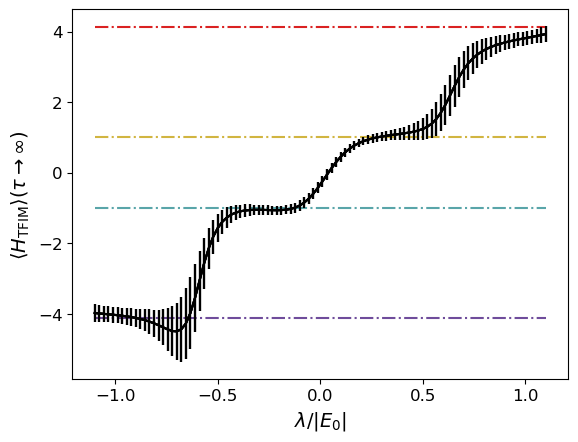

In [74]:
for i, e in enumerate(E):
    plt.plot(λs / abs(E[0]), e * np.ones(λs.shape[0]) ,
            '-.', color=colors(i))
    plt.errorbar(λs / abs(E[0]), calculated_energies-λs, yerr=sweep_prop_err, color='k')
    
plt.ylabel("$\\langle H_{\\mathrm{TFIM}} \\rangle(\\tau \\rightarrow \\infty)$")
plt.xlabel("$\\lambda/|E_0|$")
plt.savefig("sampler_sweep_results.png", format='png', dpi=300)